<h1 style="text-align:center;">Practical session 4</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Block 0. Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Block I. Data loading and basic description

The following code loads a dataset from the `inadvance_synth.csv` file using `pandas`, specifying the column separator as `;`. Once loaded, a basic analysis of the characteristics of the dataset is performed:

In [2]:
df = pd.read_csv('inadvance_synth.csv', sep=';')

### DataFrame Size:
The number of rows and columns in the DataFrame is obtained using `df.shape`.

In [3]:
df_size = df.shape
print(f"Size of DataFrame: {df_size[0]} lines, {df_size[1]} columnes")

Size of DataFrame: 38416 lines, 22 columnes


### Mean Age and Standard Deviation:
The code calculates the mean age of patients with `df['age'].mean()` and the standard deviation with `df['age'].std()`.

In [4]:
mean_age = df['age'].mean()
print(f"Mean age: {mean_age:.2f} years")

std_age = df['age'].std()
print(f"Age standard deviation: {std_age:.2f}")

Mean age: 79.40 years
Age standard deviation: 8.36


### Missing Values:
It counts the missing values in each column using `df.isnull().sum()` and sorts the columns in descending order based on the number of missing values using `.sort_values(ascending=False)`.

In [8]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Columne sorted by missing values :")
print(missing_values)

Columne sorted by missing values :
barthel                28198
num_grupoact3_HOSP     21001
proteina_c_reactiva    18175
urea                   14260
codidiagingreso        11378
glucosa                 9228
potasio                 8646
rdw_sd                  8334
rdw_cv                  8334
hematocrito             8302
leucocitos              8302
sodio                   8142
creatinina              7951
drg                     3640
numurgenciasprevias      552
metastatic_tumor          77
charlson                  77
Unnamed: 0                 0
age                        0
estancias                  0
codservicioreal            0
label                      0
dtype: int64


### Categorical Variables:
The code identifies object-type columns (categories) using `df.select_dtypes(include=['object']).columns`. This helps in knowing which columns will need special treatment during preprocessing.

In [7]:
categorical_variables = df.select_dtypes(include=['object']).columns
print("Categorical variables :")
print(categorical_variables)

Categorical variables :
Index(['codidiagingreso', 'codservicioreal'], dtype='object')


### Positive and Negative Case Distribution:
It extracts the label column (`label`) and counts the number of positive and negative cases. This is crucial to understand the class distribution.

In [10]:
label_column = df['label']
positive_cases = (label_column == 1).sum()
negative_cases = (label_column == 0).sum()
print(f"Positive case: {positive_cases}")
print(f"Negative case: {negative_cases}")

Positive case: 13431
Negative case: 24985


# Block II. Data preprocessing

The following code begins by splitting the dataset into features (`X`) and labels (`y`). Then, it separates the data into training and test sets using an 80/20 split, with `random_state=42` to ensure reproducibility. Afterward, the code identifies numeric and categorical features, setting up appropriate transformations for each type.

### Training and Test Set Sizes:
The dataset is split into training and test sets using `train_test_split()`. This results in 80% of the data for training and 20% for testing, resulting in the following number of samples:

In [14]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Number of samples in train: {X_train.shape[0]} lines")
print(f"Number of samples in test: {X_test.shape[0]} lines")

Number of samples in train: 30732 lines
Number of samples in test: 7684 lines


### Categorical Variable Transformation:
A pipeline for categorical features uses `SimpleImputer` with the `most_frequent` strategy to fill missing values and `OneHotEncoder` with `handle_unknown='ignore'` to encode categories as binary vectors. This strategy prevents errors if an unseen category appears in the test set by ignoring it, ensuring that the model can handle new categories gracefully.

### Missing Value Imputation:
Numeric features are handled with a separate pipeline that applies `SimpleImputer` with the `mean` strategy, which fills missing numeric values with the column mean. This approach is simple and effective for numeric data, but if a column has no missing values in training and they appear in testing, the model will still handle them by applying the same mean imputation from training.

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Using the Whole Dataset for Preprocessing:
Using the entire dataset for imputing missing values and encoding categories might seem convenient, but it introduces data leakage. By exposing the model to information from the test set during training, it risks overfitting and results in overly optimistic performance metrics. To avoid this, the preprocessing steps should only use the training data, ensuring a fair evaluation on the test set.

# Block III. Modelling & Evaluation

The following code completes the machine learning workflow by transforming the data, training a Random Forest model, evaluating its performance, and visualizing the results.

### Model Creation and Training:
The code initializes a `RandomForestClassifier` with `random_state=42` for reproducibility. The model is trained using the transformed training data (`X_train_transformed`) and corresponding labels (`y_train`).

In [16]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

### Prediction and AUC-ROC Calculation:
The model calculates probabilities for the positive class using `predict_proba()` on the test set. The `roc_auc_score()` function then computes the AUC-ROC, which measures the model's ability to distinguish between positive and negative cases, with values closer to 1 indicating better performance.

In [17]:
y_prob = rf_model.predict_proba(X_test_transformed)[:, 1]

auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.8961113376926627


### Additional Metrics: Accuracy, Sensitivity, and Specificity:
The model predicts class labels with `predict()` on the test set and computes the accuracy using `accuracy_score()`, which provides an overall measure of correct predictions. The code then calculates the sensitivity (True Positive Rate) and specificity (True Negative Rate) from the confusion matrix, offering insights into the model's performance for both positive and negative cases.

In [18]:
y_pred = rf_model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn)
print(f"Sensitivity (True Positive Rate): {sensitivity}")

specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity}")

Accuracy: 0.825351379489849
Sensitivity (True Positive Rate): 0.653558052434457
Specificity (True Negative Rate): 0.9168328679696849


### ROC Curve Plotting:
The ROC curve, generated with `roc_curve()`, illustrates the trade-off between the True Positive Rate and False Positive Rate. The plotted curve provides a visual representation of the model's discriminative power, with the AUC shown in the legend for easy reference.

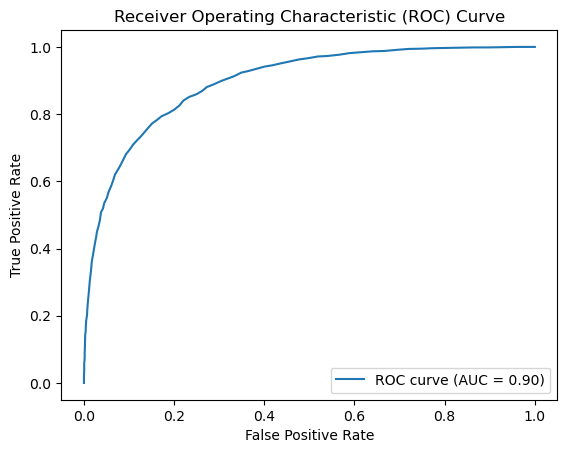

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_roc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Hyperparameter optimization

The following code sets up and performs Bayesian hyperparameter optimization on a Random Forest classifier within a pipeline. This approach helps fine-tune model parameters by focusing on promising regions of the search space, ultimately finding the optimal configuration for improved performance.

### 1. Pipeline Creation:
The code constructs a `Pipeline` with two steps:
   - **Preprocessor**: Applies the transformations defined earlier, such as imputing missing values and encoding categorical variables.
   - **Classifier**: Uses `RandomForestClassifier` as the predictive model, with `random_state=42` to ensure reproducibility. The model's hyperparameters will be optimized.

In [20]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### 2. Hyperparameter Search Space Definition:
The parameter space is defined using:
   - `Integer()` for continuous integer values like `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`, specifying the range for each.
   - `Categorical()` for discrete options like `max_features`, which includes options `sqrt` and `log2`.
This flexible setup allows for exploring various configurations that can significantly affect model performance.

In [21]:
param_space = {
    'classifier__n_estimators': Integer(100, 500),
    'classifier__max_depth': Integer(5, 50),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf': Integer(1, 20),
    'classifier__max_features': Categorical(['sqrt', 'log2'])
}

### 3. Bayesian Optimization with BayesSearchCV:
The `BayesSearchCV` object performs Bayesian optimization over 32 iterations (`n_iter=32`), using 5-fold cross-validation (`cv=5`) and `roc_auc` as the scoring metric to optimize AUC-ROC. The search runs in parallel (`n_jobs=-1`) for efficiency.
   - **Bayesian Optimization**: Unlike grid or random search, this method uses past evaluation results to model the search space and identify regions likely to yield better results, improving efficiency.

In [22]:
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=32,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          Index(['Unnamed: 0', 'age', 'barthel', 'charlson', 'creatinina', 'drg',
       'estancias', 'glucosa', 'hematocrito', 'leucocitos', 'metastatic_tumor',
       'num_grupoact3_HOSP', 'numurgenciasprevias', 'potasio',
       'proteina_c_reacti...
                             'classifier__max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'classifier__min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'classifier__min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize')})

### 4. Best hyperparameters:

In [23]:
best_model = bayes_search.best_estimator_
print(f"Mejores parámetros: {bayes_search.best_params_}")

Mejores parámetros: OrderedDict([('classifier__max_depth', 50), ('classifier__max_features', 'sqrt'), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 2), ('classifier__n_estimators', 500)])


### 5. Model Evaluation:
Once the best model is found, the code evaluates it on the test set by calculating key metrics:
   - **AUC-ROC**: Measures the model's ability to distinguish between classes.
   - **Accuracy**: Overall correctness of predictions.
   - **Sensitivity (True Positive Rate)** and **Specificity (True Negative Rate)**: Provide insights into the model's performance on positive and negative classes.

In [24]:
y_prob = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC en test: {auc_roc}")

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensibilidad (Tasa de Verdaderos Positivos): {sensitivity}")
print(f"Especificidad (Tasa de Verdaderos Negativos): {specificity}")

AUC-ROC en test: 0.8990502996105287
Accuracy en test: 0.8262623633524206
Sensibilidad (Tasa de Verdaderos Positivos): 0.6438202247191012
Especificidad (Tasa de Verdaderos Negativos): 0.9234144395692062


### 6. Bayesian Optimization Visualization:
The code visualizes the Bayesian optimization results to understand the impact of each parameter and track convergence:
 - **Objective Function Plot**: Plots the objective values over the parameter space, showing areas where the model achieved the highest AUC-ROC.
 - **Parameter Distributions**: Histograms show how often each parameter value was selected, providing insights into preferred ranges.
 - **Convergence Plot**: Tracks the best ROC-AUC score across iterations, illustrating how the optimization improved with each step.

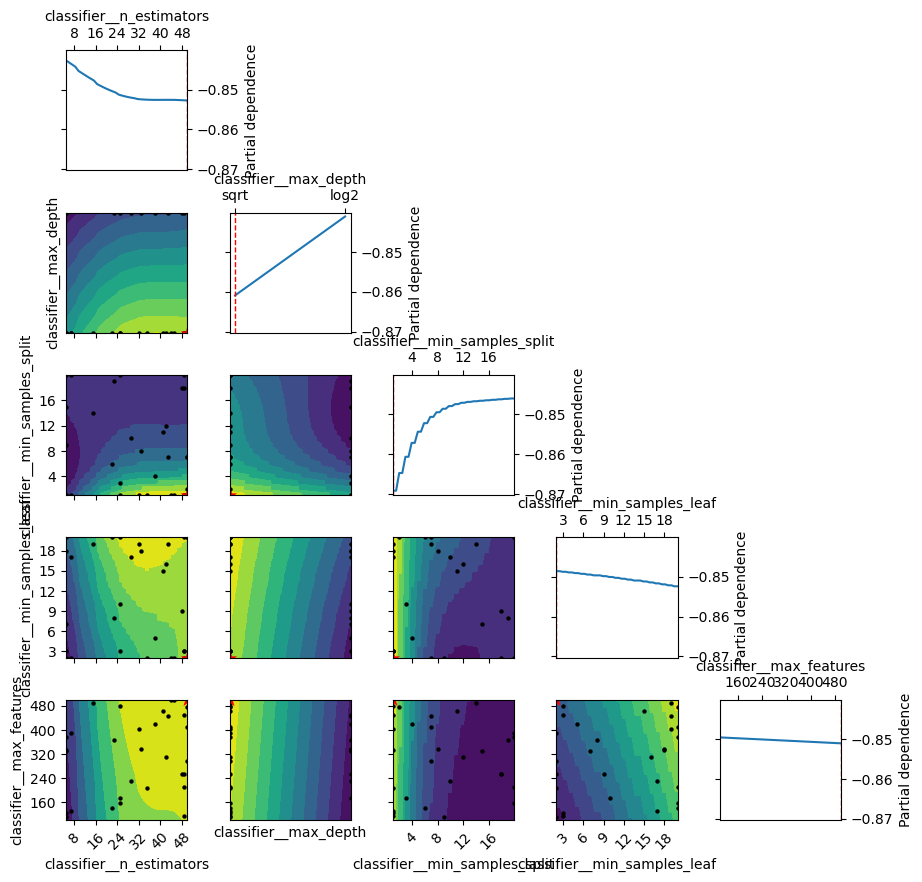

In [25]:
from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_evaluations

_ = plot_objective(bayes_search.optimizer_results_[0],
                   dimensions=["classifier__n_estimators", "classifier__max_depth", 
                               "classifier__min_samples_split", "classifier__min_samples_leaf",
                              "classifier__max_features"],
                   n_minimum_search=1000)
plt.show()

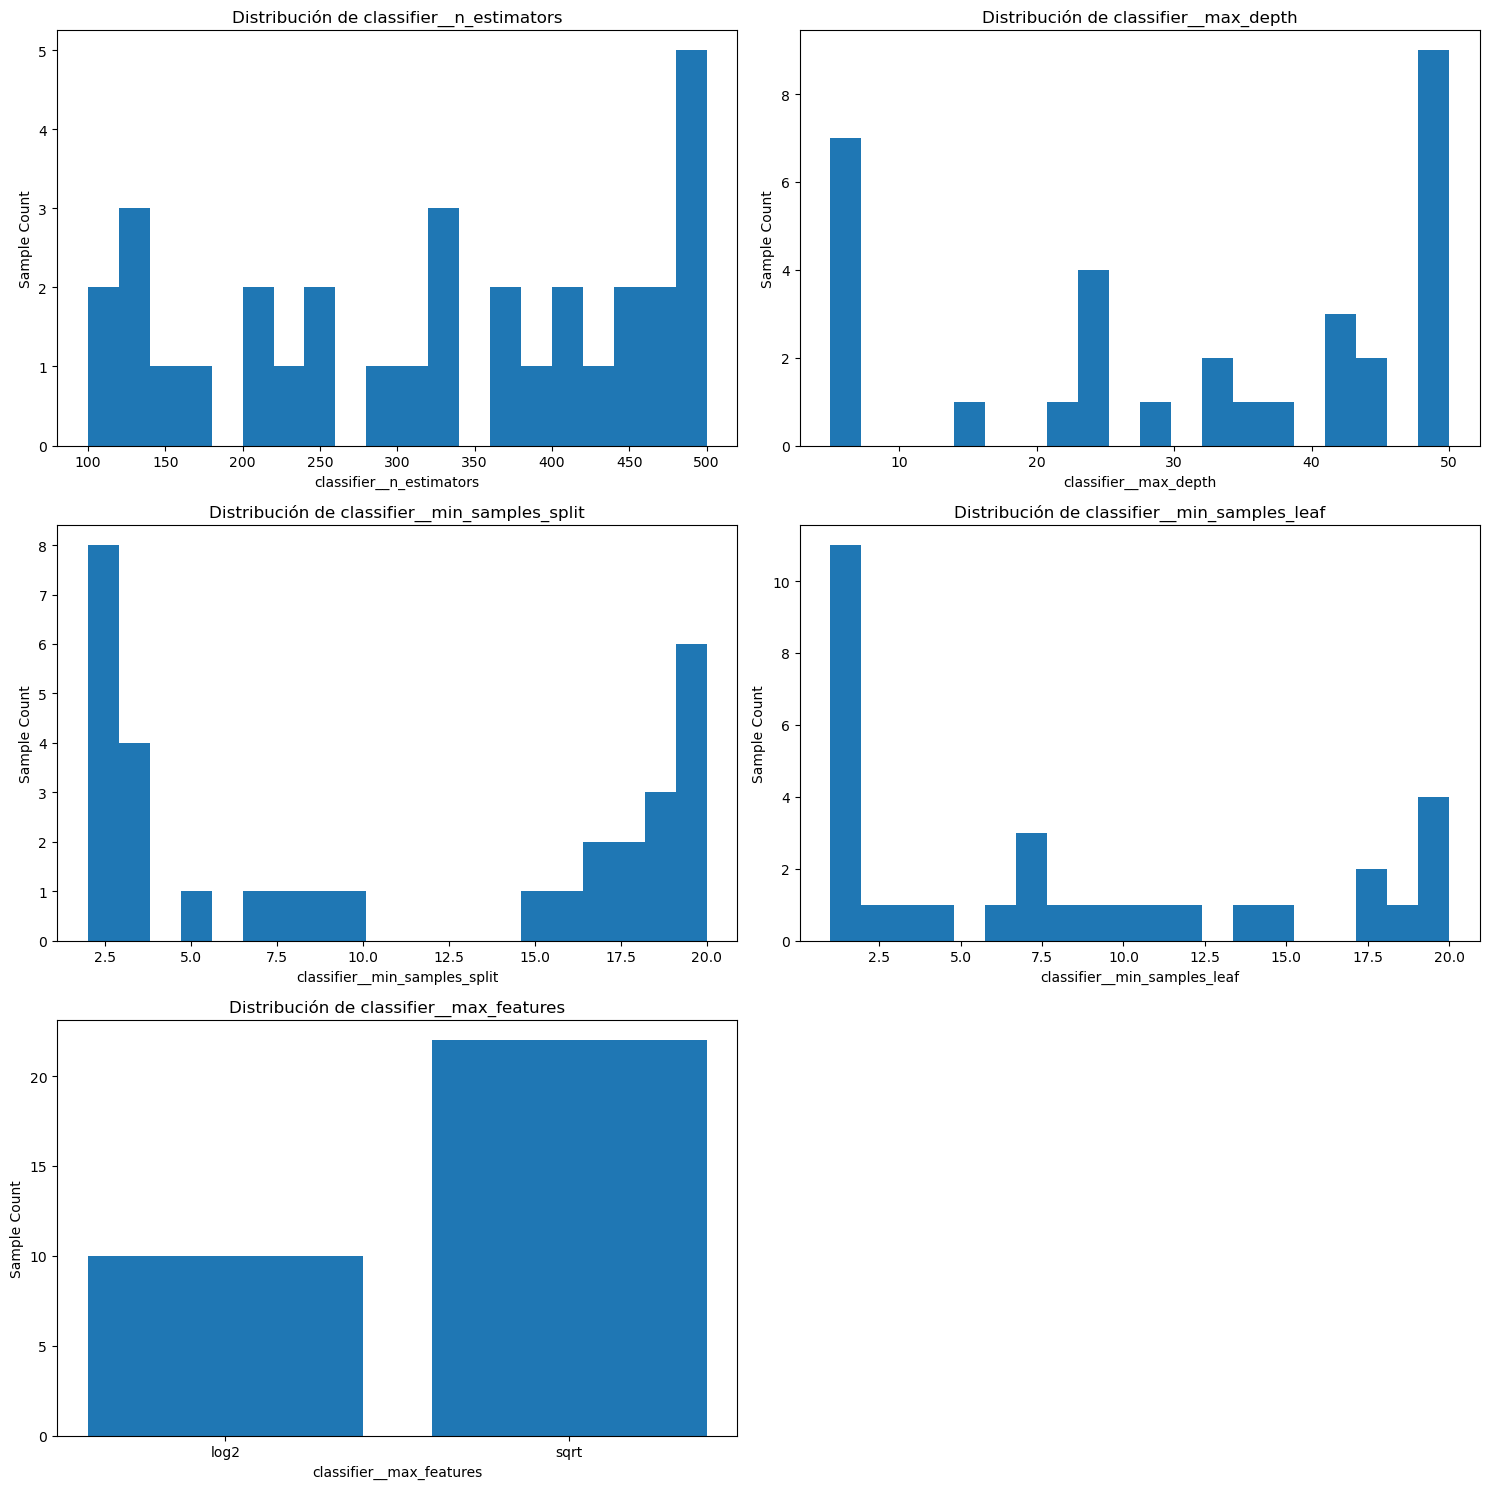

In [26]:
hyperparameters = [
    "classifier__n_estimators",
    "classifier__max_depth", 
    "classifier__min_samples_split",
    "classifier__min_samples_leaf",
    "classifier__max_features"
]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, param in enumerate(hyperparameters):
    plot_histogram(
        bayes_search.optimizer_results_[0],
        dimension_identifier=param,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {param}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

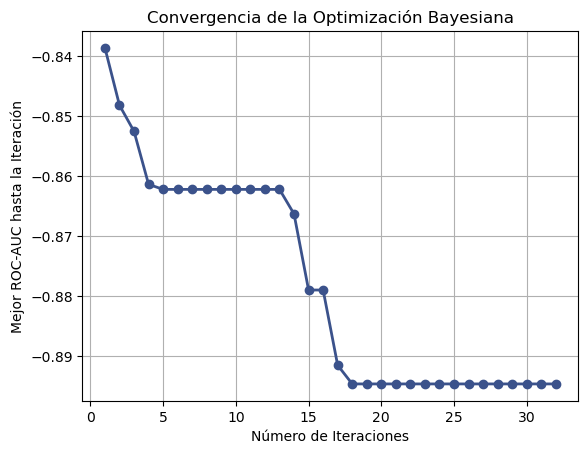

In [27]:
plt.figure()
plot_convergence(bayes_search.optimizer_results_[0])
plt.title('Convergencia de la Optimización Bayesiana')
plt.xlabel('Número de Iteraciones')
plt.ylabel('Mejor ROC-AUC hasta la Iteración')
plt.show()